In [475]:
import pandas as pd
import numpy as np

In [476]:
df = pd.read_csv('Report Orders - Sheet1.csv')

In [477]:
df = df.rename(columns={'User ID':'user_id',
                  'Amount':'amount',
                  'Currency':'currency',
                  'Status':'status',
                  'Payment Method': 'payment_method',
                  'Created At': 'created_at',
                  'Description': 'description'})

In [478]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['data_chunk_date'] = df.created_at.dt.date

/var/folders/dn/f65zy3pj4y9fm0d3kplg7n3r0000gn/T/ipykernel_49456/3146473016.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



## **0. ДОСЛІДЖЕННЯ ЛОГІКИ РОБОТИ ТРАНЗАКЦІЙНИХ СТАТУСІВ**

In [479]:
temp = df.copy()

### **0.1. Дослідимо які є статуси**

In [480]:
print(f'Статуси які наявні в даних = {temp.status.unique()}')

Статуси які наявні в даних = ['success' 'declined' 'refunded']


### **0.2. Промаркуємо всі транзакції в залежності від їхнього статусі, для того щоб в подальшому оцінювати юзери з якими транзакціями зустрічаються, а також, чи можуть змінюватись транзакції**

In [481]:
temp['have_success'] = temp.status == 'success'
temp['have_declined'] = temp.status == 'declined'
temp['have_refunded'] = temp.status == 'refunded'

### **0.3. Просумуємо для кожного юзера кількість транзакцій з різними статусами**

In [482]:
temp = temp.groupby('user_id').agg(number_of_success_transactions=('have_success','sum'),
                           number_of_declined_transactions=('have_declined','sum'),
                           number_of_refunded_transactions=('have_refunded','sum')).reset_index()
temp.head()

,user_id,number_of_success_transactions,number_of_declined_transactions,number_of_refunded_transactions
0,USER_410001,3,0,0
1,USER_410004,1,0,0
2,USER_410006,2,4,0
3,USER_410033,0,1,0
4,USER_410035,0,2,0


### **0.4. Дослідимо, чи є юзери з 0 успішних транзакцій в даних**

In [483]:
temp[(temp.number_of_success_transactions == 0)].head()

,user_id,number_of_success_transactions,number_of_declined_transactions,number_of_refunded_transactions
3,USER_410033,0,1,0
4,USER_410035,0,2,0
17,USER_410120,0,1,0
21,USER_410137,0,0,1
22,USER_410151,0,1,0


In [484]:
print(f'Кількість користувачів з 0 успішних транзакцій = {temp[(temp.number_of_success_transactions == 0)].user_id.nunique()}')

Кількість користувачів з 0 успішних транзакцій = 623


### **0.5. Бачимо що є 623 користувачів які мають 0 успішних транзакцій, виберемо їх з таблиці вище, і подивимось які в них транзакції і статуси бувають.**

In [485]:
df[df.user_id == 'USER_410033']

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
4573,USER_410033,69,USD,declined,Apple Pay,2022-09-17 01:47:00,Subscription for user 410033 by 2022_09,2022-09-17


In [486]:
df[df.user_id == 'USER_410035']

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
4569,USER_410035,69,USD,declined,Apple Pay,2022-09-17 01:54:00,Subscription for user 410035 by 2022_09,2022-09-17
4570,USER_410035,69,USD,declined,Apple Pay,2022-09-17 01:54:00,Subscription for user 410035 by 2022_09,2022-09-17


In [487]:
df[df.user_id == 'USER_410137']

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
4543,USER_410137,69,USD,refunded,Card,2022-09-17 18:00:00,Subscription for user 410137 by 2022_09,2022-09-17


### **0.6. Обираючи рандомно, бачимо, що такі користувачі, мають як і refunded так і declined статуси але перевіримо чи можуть вони мати обидва.**

In [488]:
temp[(temp.number_of_success_transactions == 0) 
    & (temp.number_of_declined_transactions > 0) 
    & (temp.number_of_refunded_transactions > 0)].head()

,user_id,number_of_success_transactions,number_of_declined_transactions,number_of_refunded_transactions
61,USER_410458,0,1,1
132,USER_410924,0,1,1
149,USER_411053,0,1,1
151,USER_411087,0,1,3
169,USER_411193,0,3,1


In [489]:
df[df.user_id == 'USER_410458'].sort_values(by='created_at')

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
4446,USER_410458,69,USD,declined,Card,2022-09-19 11:02:00,Subscription for user 410458 by 2022_09,2022-09-19
4445,USER_410458,69,USD,refunded,Card,2022-09-19 11:03:00,Subscription for user 410458 by 2022_09,2022-09-19


In [490]:
df[df.user_id == 'USER_410924'].sort_values(by='created_at')

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
4217,USER_410924,69,USD,refunded,Apple Pay,2022-09-22 03:24:00,Subscription for user 410924 by 2022_09,2022-09-22
4216,USER_410924,199,USD,declined,Apple Pay,2022-09-22 03:45:00,Upsell 1 for user 410924 by 2022_09,2022-09-22


### **0.7. Дослідимо чи є користувачі котрі мають всі 3 статиси в історії**

In [491]:
temp[(temp.number_of_success_transactions > 1) 
    & (temp.number_of_declined_transactions > 0) 
    & (temp.number_of_refunded_transactions > 0)].head(10)

,user_id,number_of_success_transactions,number_of_declined_transactions,number_of_refunded_transactions
129,USER_410915,2,2,1
1099,USER_417840,2,1,1
1408,USER_42961,2,1,1
1559,USER_43733,4,3,1
1619,USER_44077,2,5,1
1634,USER_44154,3,1,1
1660,USER_44363,3,1,1
1781,USER_45062,2,4,1
1809,USER_45243,3,4,1
1873,USER_45571,2,1,1


In [492]:
df[df.user_id == 'USER_410915'].sort_values(by='created_at')

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
4224,USER_410915,69,USD,success,Card,2022-09-22 02:00:00,Subscription for user 410915 by 2022_09,2022-09-22
4222,USER_410915,199,USD,refunded,Card,2022-09-22 02:02:00,Upsell 1 for user 410915 by 2022_09,2022-09-22
1520,USER_410915,69,USD,declined,Card,2022-10-22 02:00:00,Renew subscription,2022-10-22
1427,USER_410915,69,USD,declined,Card,2022-10-23 02:01:00,Retry to renew subscription,2022-10-23
1234,USER_410915,69,USD,success,Card,2022-10-25 02:01:00,Retry to renew subscription,2022-10-25


In [493]:
temp[(temp.number_of_success_transactions == 0)
    & (temp.number_of_declined_transactions == 0)
    & (temp.number_of_refunded_transactions > 0)].head()

,user_id,number_of_success_transactions,number_of_declined_transactions,number_of_refunded_transactions
21,USER_410137,0,0,1
23,USER_410161,0,0,1
103,USER_410764,0,0,1
167,USER_411180,0,0,1
213,USER_411496,0,0,1


In [494]:
df[df.user_id == 'USER_410137'].sort_values(by='created_at')

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
4543,USER_410137,69,USD,refunded,Card,2022-09-17 18:00:00,Subscription for user 410137 by 2022_09,2022-09-17


## **0.8. Дослідимо чи є користувачі в яких транзакції refunded передують success**

In [495]:
import pandas as pd

# Ensure the DataFrame is sorted by user_id and created_at
temp = df.sort_values(by=['user_id', 'created_at'])

# Initialize an empty list to store user_ids with refunded before success
users_with_refunded_before_success = []

# Iterate over each user group
for user_id, group in temp.groupby('user_id'):
    statuses = group['status'].tolist()
    # Check if refunded appears before success in the status list
    if 'refunded' in statuses and 'success' in statuses:
        if statuses.index('refunded') < statuses.index('success'):
            users_with_refunded_before_success.append(user_id)

# Output the list of user_ids
users_with_refunded_before_success

['USER_411750', 'USER_412555', 'USER_416201', 'USER_43921']

In [496]:
df[df.user_id == 'USER_411750'].sort_values(by='created_at')

,user_id,amount,currency,status,payment_method,created_at,description,data_chunk_date
3631,USER_411750,69,USD,declined,Card,2022-09-29 21:38:00,Subscription for user 411750 by 2022_09,2022-09-29
3630,USER_411750,69,USD,refunded,Apple Pay,2022-09-29 21:40:00,Subscription for user 411750 by 2022_09,2022-09-29
727,USER_411750,69,USD,success,Apple Pay,2022-10-29 21:40:00,Renew subscription,2022-10-29


# Аналіз логіки логування транзакцій

## 1. Теоритична логіка логування транзакцій
- Якщо транзакція **не пройшла**, вона отримує статус `declined`, і цей статус **неможливо змінити**.
- Якщо транзакція **пройшла успішно**, вона отримує статус `success`, який може бути змінений на `refunded`, якщо транзакцію було скасовано.

## 2. Підтвердження припущення
Це припущення базується на аналізі даних, який показав такі особливості:
- У датасеті є користувачі, які **не мають транзакцій зі статусом `success`**, але мають транзакції зі статусом `refunded`. 
- Також є користувачі, які мають **тільки транзакції зі статусом `declined`**.
- Транзакції зі статусом `refunded` часто мають **іншу суму** (`amount`), ніж транзакції зі статусом `success`, які передують їм. Це свідчить про те, що `refunded` **не завжди прив'язаний до успішної транзакції**.
- Є користувачі, які мають лише **одну транзакцію зі статусом `refunded`**, без інших транзакцій.

## 3. Додатковий аналіз
Щоб підтвердити припущення, було перевірено:
- Чи є користувачі, у яких транзакція зі статусом `refunded` **передує** транзакції зі статусом `success`.

### Результати аналізу:
- Виявлено, що такі користувачі **існують**. Це означає, що транзакція зі статусом `refunded` **може передувати** транзакції зі статусом `success`.


## 4. Висновки
На основі даних можна зробити висновок, що:
1. Транзакції зі статусом `refunded` можуть існувати без попередньої транзакції зі статусом `success`.
2. Статус `declined` є кінцевим і не може змінюватися.
3. Транзакції зі статусом `refunded`, що мають іншу суму, можуть бути окремими, а не зміною попередньої транзакції.

## **0.9. Дослідження логіки моделей для різних GEO**

### **Спостереження:**
- У даних присутні користувачі з **Канади** та **США**.

### **Можливі сценарії:**
1. **Незалежні моделі для різних GEO**:
   - Можливо, кожна країна працює окремо, і транзакції не пов’язані між собою.
2. **Оплата у двох валютах незалежно від GEO**:
   - Користувачі можуть здійснювати транзакції в різних валютах (наприклад, USD і CAD), незалежно від свого географічного розташування.

### **Рекомендації для подальшого аналізу:**
- При майбутніх розрахунках необхідно враховувати **кількість користувачів у кожному GEO**, щоб уникнути **перекосів** у результатах через недостатній розмір вибірки.

## **0.10. Дослідження користувачів з транзакціями в CAD**

### Постановка задачі:
- Перевіримо, чи є користувачі, які мають транзакції у валюті **CAD**, а також транзакції в іншій валюті.


In [497]:
lst_of_users_w_CAD = df[df.currency == 'CAD'].user_id.unique()


currency_counts = df[df.user_id.isin(lst_of_users_w_CAD)].currency.value_counts().reset_index()
currency_counts.columns = ['Currency', 'Transaction Count']

print("Валюти та кількість транзакцій для користувачів, які мали хоча б одну транзакцію в CAD:")
print(currency_counts)

Валюти та кількість транзакцій для користувачів, які мали хоча б одну транзакцію в CAD:
  Currency  Transaction Count
0      CAD                175


### Результати:
- Виявлено, що користувачі, які мали хоча б одну транзакцію у валюті **CAD**, мали транзакції **лише у CAD**.
- Загальна кількість таких транзакцій: **175**.

### Висновки:
- Користувачі, які використовують валюту CAD, не здійснюють транзакцій в інших валютах.
- Це свідчить про можливу залежність валюти транзакції від географічного розташування користувача або інших обмежень.

In [498]:
print(f'Загальна кількість користувачів, з Канади = {len(lst_of_users_w_CAD)}')
print(f'Загальна кількість користувачів, які не з Канади = {df[~df.user_id.isin(lst_of_users_w_CAD)].user_id.nunique()}')

Загальна кількість користувачів, з Канади = 110
Загальна кількість користувачів, які не з Канади = 2342


## **0.12. Висновки щодо транзакцій у CAD та USD**

### Результати аналізу:
- **Користувачі, які здійснюють транзакції у валюті CAD**, не мають операцій в інших валютах.
- Це свідчить про те, що:
  - У **США** використовується лише валюта **USD**.
  - У **Канаді** використовується лише валюта **CAD**.
  - Мультивибір валюти відсутній.

### Проблематика:
- Було б корисно розділити метрики для кожного окремого GEO (США та Канада).
- Однак, у нашому датасеті кількість користувачів значно відрізняється:
  - **Канада**: лише **110 користувачів**.
  - **США**: **2342 користувачі**.

### Компромісне рішення:
- **Об'єднати два GEO** для подальшого аналізу.
- **Конвертувати транзакції у CAD до USD**:
  - Використати фіксований коефіцієнт конвертації: **1 CAD = 0.75 USD**.
  - (Примітка: У фінальній версії розрахунків можна враховувати **щоденні курси валют** для більш точної конвертації.)

In [499]:
# Приведення стовпця amount до float перед виконанням операції
df['amount'] = df['amount'].astype(float)

# Застосування змін для рядків з currency == 'CAD'
df.loc[df['currency'] == 'CAD', 'amount'] *= 0.75

## **1. Розрахунок ARPPU (Average Revenue Per Paying User) для кожної когорти**

### **Як ми це зробимо:**

1. **Очищення даних:**
   - Видалимо транзакції зі статусами `refunded` і `declined`, оскільки вони не відображають дохід.
   - Залишимо лише транзакції зі статусом `success` для точного розрахунку Revenue.

2. **Відбір платоспроможних користувачів:**
   - Залишимо тільки тих користувачів, які здійснили хоча б одну успішну покупку (`success`).
   - Відфільтруємо дані, щоб враховувати лише цих користувачів.

3. **Використання конвертації валюти:**
   - Для об’єднаного аналізу **США** та **Канади** будемо працювати з валютою USD.
   - Попередньо транзакції у CAD були конвертовані в USD за курсом **1 CAD = 0.75 USD**.

4. **Дослідження оптимальної розбивки на когорти:**
   - Виконаємо розрахунок ARPPU для трьох варіантів когорт:
     1. **Денна когорта (Daily):**
        - Користувачі групуються за першою транзакцією у межах одного дня.
     2. **Тижнева когорта (Weekly):**
        - Користувачі групуються за першою транзакцією у межах одного тижня.
     3. **Місячна когорта (Monthly):**
        - Користувачі групуються за першою транзакцією у межах одного місяця.
   - Порівняємо отримані результати за розміром когорт, точністю та стабільністю метрик.

> Примітка: Остаточний вибір типу когорти залежатиме від аналізу стабільності та варіативності метрик ARPPU у кожному підході.

In [500]:
temp = df.copy()

In [501]:
temp = temp[temp.status == 'success']

Для аналізу даних користувачів потрібно визначити їхні когортні групи залежно від дати першої транзакції. Ми перетворимо дати транзакцій на три типи когорт:

- **Daily cohort**:
  - Користувачі групуються за першою транзакцією у межах одного дня.
  - **Приклад**: транзакція 2023-12-05 потрапить у когорту 2023-12-05.

- **Weekly cohort**:
  - Транзакції групуються по тижнях, починаючи з понеділка.
  - **Приклад**: транзакція 2023-12-06 потрапить у тиждень, який починається 2023-12-04.

- **Monthly cohort**:
  - Транзакції групуються по місяцях.
  - **Приклад**: транзакція 2023-12-15 потрапить у місяць, що починається 2023-12-01.


In [502]:
# Перетворюємо дату транзакції на дату в днях, тижнях і місяцях

# Daily cohort: Наприклад, транзакція 2023-12-05 потрапить у когорту 2023-12-05
temp['daily_cohort'] = temp['created_at'].dt.date
temp['daily_cohort'] = pd.to_datetime(temp['daily_cohort'])

# Weekly cohort: Транзакції групуються по тижнях, починаючи з понеділка
# Наприклад, транзакція 2023-12-06 потрапить у тиждень, який починається 2023-12-04
temp['weekly_cohort'] = temp['created_at'].dt.to_period('W').apply(lambda r: r.start_time)

# Monthly cohort: Транзакції групуються по місяцях
# Наприклад, транзакція 2023-12-15 потрапить у місяць, що починається 2023-12-01
temp['monthly_cohort'] = temp['created_at'].dt.to_period('M').apply(lambda r: r.start_time)

Для кожного користувача визначимо час першої покупки, залежно від типу когорти. Це потрібно для точного групування даних.

- **Daily cohort**:
  - Додаємо дату першої покупки у денній когорті.
  - **Приклад**: якщо користувач зробив першу покупку 2023-12-01, то `cohort_day` буде "2023-12-01".

- **Weekly cohort**:
  - Додаємо дату першої покупки у тижневій когорті.
  - **Приклад**: якщо користувач зробив першу покупку 2023-12-01, то `cohort_week` буде "2023-11-27" (початок тижня).

- **Monthly cohort**:
  - Додаємо дату першої покупки у місячній когорті.
  - **Приклад**: якщо користувач зробив першу покупку 2023-12-01, то `cohort_month` буде "2023-12-01" (початок місяця).

In [503]:
# Для кожного юзера додаємо час його першої покупки, в залежності від типу когорти

# Додаємо дату першої покупки у денній когорті
# Наприклад: якщо користувач зробив першу покупку 2023-12-01, то cohort_day буде "2023-12-01"
temp = temp.merge(
    temp.groupby('user_id').agg(cohort_day=('daily_cohort', 'min')).reset_index(),
    how='inner',
    on='user_id'
)

# Додаємо дату першої покупки у тижневій когорті
# Наприклад: якщо користувач зробив першу покупку 2023-12-01, то cohort_week буде "2023-11-27" (початок тижня)
temp = temp.merge(
    temp.groupby('user_id').agg(cohort_week=('weekly_cohort', 'min')).reset_index(),
    how='inner',
    on='user_id'
)

# Додаємо дату першої покупки у місячній когорті
# Наприклад: якщо користувач зробив першу покупку 2023-12-15, то cohort_month буде "2023-12-01" (початок місяця)
temp = temp.merge(
    temp.groupby('user_id').agg(cohort_month=('monthly_cohort', 'min')).reset_index(),
    how='inner',
    on='user_id'
)

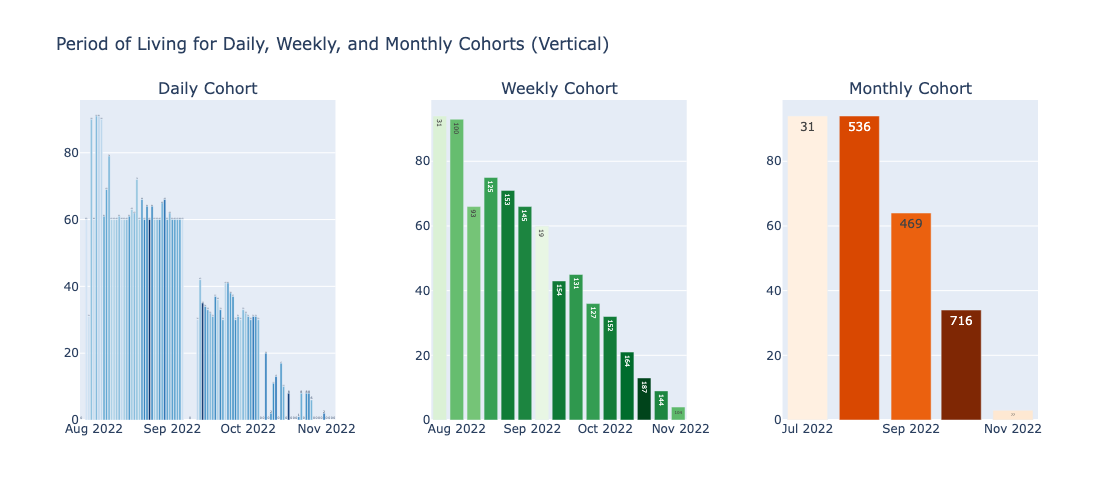

In [504]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Дані для денної, тижневої та місячної когорт
temp_daily = temp.groupby('cohort_day').agg(
    first_transaction_day=('daily_cohort', 'min'),
    last_transaction_day=('daily_cohort', 'max'),
    number_of_buyers=('user_id', 'nunique'),
    number_of_transaction=('user_id', 'count')
).reset_index()
temp_daily['period_of_living'] = (temp_daily.last_transaction_day - temp_daily.first_transaction_day).dt.days

temp_weekly = temp.groupby('cohort_week').agg(
    first_transaction_day=('daily_cohort', 'min'),
    last_transaction_day=('daily_cohort', 'max'),
    number_of_buyers=('user_id', 'nunique'),
    number_of_transaction=('user_id', 'count')
).reset_index()
temp_weekly['period_of_living'] = (temp_weekly.last_transaction_day - temp_weekly.first_transaction_day).dt.days

temp_monthly = temp.groupby('cohort_month').agg(
    first_transaction_day=('daily_cohort', 'min'),
    last_transaction_day=('daily_cohort', 'max'),
    number_of_buyers=('user_id', 'nunique'),
    number_of_transaction=('user_id', 'count')
).reset_index()
temp_monthly['period_of_living'] = (temp_monthly.last_transaction_day - temp_monthly.first_transaction_day).dt.days

# Визначення максимумів для кількості покупців
max_buyers_daily = temp_daily['number_of_buyers'].max()
max_buyers_weekly = temp_weekly['number_of_buyers'].max()
max_buyers_monthly = temp_monthly['number_of_buyers'].max()

# Створення subplot
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("Daily Cohort", "Weekly Cohort", "Monthly Cohort"),
    shared_yaxes=False,
    horizontal_spacing=0.1
)

# Додавання графіка для денної когорти (без тексту покупців)
fig.add_trace(
    go.Bar(
        x=temp_daily['cohort_day'],
        y=temp_daily['period_of_living'],
        marker=dict(
            color=temp_daily['number_of_buyers'],
            colorscale="Blues",
            cmin=0,
            cmax=max_buyers_daily
        ),
        name="Daily Cohort",
        text=temp_daily['period_of_living'],  # Додано текст періоду життя
        textposition='outside'
    ),
    row=1, col=1
)

# Додавання графіка для тижневої когорти
fig.add_trace(
    go.Bar(
        x=temp_weekly['cohort_week'],
        y=temp_weekly['period_of_living'],
        marker=dict(
            color=temp_weekly['number_of_buyers'],
            colorscale="Greens",
            cmin=0,
            cmax=max_buyers_weekly
        ),
        name="Weekly Cohort",
        text=temp_weekly['number_of_buyers'],  # Додано текст із кількістю покупців
        textposition='inside'
    ),
    row=1, col=2
)

# Додавання графіка для місячної когорти
fig.add_trace(
    go.Bar(
        x=temp_monthly['cohort_month'],
        y=temp_monthly['period_of_living'],
        marker=dict(
            color=temp_monthly['number_of_buyers'],
            colorscale="Oranges",
            cmin=0,
            cmax=max_buyers_monthly
        ),
        name="Monthly Cohort",
        text=temp_monthly['number_of_buyers'],  # Додано текст із кількістю покупців
        textposition='inside'
    ),
    row=1, col=3
)

# Налаштування загального вигляду
fig.update_layout(
    height=500,  # Висота графіка
    width=1200,  # Ширина графіка
    title_text="Period of Living for Daily, Weekly, and Monthly Cohorts (Vertical)",
    showlegend=False
)

# Відображення графіка
fig.show()

### Висновки:

Для завдання розрахунку ARPPU (Average Revenue Per Paying User) оптимальною буде **тижнева розбивка** з таких причин:
1. Вона дозволяє враховувати як короткострокові зміни (зміни цін, вплив акцій), так і довгострокові тренди.
2. Тиждень є достатньо широким періодом для акумуляції покупок, але не настільки довгим, щоб втратити деталізацію.
3. **Оптимальний розмір вибірки користувачів**:
   - Кожного тижня є достатня кількість користувачів для розрахунків ~ 100+. 
   - Винятком є тиждень **5 вересня**, де кількість користувачів становить лише **19**, що може призвести до статистичних перекосів у результатах. А також перший тиждень де 31 користувач.

## **Опис коду нижче**

Цей код використовується для оцінки мінімальної кількості днів, які прожили всі користувачі у кожній когорті. Мета – визначити, за яким часовим проміжком можна чесно порівнювати показники між когортами.

### **Основна логіка:**
1. Для кожного користувача обчислюється кількість днів з моменту його останньої транзакції до часу останньої транзакції в даних.
2. Для кожної когорти визначається мінімальна кількість днів, які прожили всі користувачі.
3. Це дозволяє вирішити:
   - **Які когорти можна порівнювати на певний день.**
   - Наприклад, усі когорти можна коректно порівнювати на 0 день, але лише ті, які мають мінімум 30 днів проживання, можна аналізувати на 30 день.

In [505]:
temp['diff'] = (pd.to_datetime(temp.data_chunk_date.max()) - pd.to_datetime(temp.data_chunk_date)).dt.days

In [506]:
temp1 = temp.groupby(['user_id', 'cohort_week']).agg(days_leaving=('diff','max')).reset_index()

In [507]:
temp1.groupby('cohort_week').agg(max_value_live_all_buyer_in_cohort=('days_leaving','min')).reset_index()

,cohort_week,max_value_live_all_buyer_in_cohort
0,2022-07-25,96
1,2022-08-01,89
2,2022-08-08,82
3,2022-08-15,75
4,2022-08-22,68
5,2022-08-29,61
6,2022-09-05,54
7,2022-09-12,47
8,2022-09-19,40
9,2022-09-26,33


### **Висновок:**
На основі цього аналізу ми бачимо що є когорти які довго прожили, а які прожили тільки 1 день. 

Оскільки наразі немає чітких бізнес-запитів та глибшого розуміння особливостей продукту, підписок, потреб команди та їхніх цілей, оптимальним є розрахунок для 0, 30 та 60 днів. Це дозволить отримати базові метрики та провести первинний аналіз, на основі якого можна буде приймати подальші рішення.

## **Опис коду нижче**

Цей код використовується для розрахунку ARPPU (Average Revenue Per Paying User) для кожної когорти на основі різних часових проміжків (0, 30, 60 днів). Мета – визначити, які когорти можна коректно порівнювати залежно від їхнього часу життя.

### **Основна логіка:**
1. **Попередня обробка даних:**
   - Додається інформація про мінімальний час життя користувачів у кожній когорті.
   - Обчислюється кількість днів між транзакцією користувача та його першою транзакцією.

2. **Фільтрація даних:**
   - Для кожного часовго проміжку (0, 30, 60 днів):
     - Залишаються тільки ті когорти, в яких мінімальний час життя всіх користувачів більший або дорівнює поточному часовому проміжку.
     - Враховуються транзакції, що відбулися не пізніше ніж через 0, 30 або 60 днів після першої транзакції користувача.

3. **Розрахунок метрик:**
   - Для кожної когорти розраховується:
     - **Кількість платоспроможних користувачів** (`buyers`).
     - **Сумарний дохід** (`revenue`).
     - **ARPPU** – середній дохід на одного платоспроможного користувача.

4. **Результати:**
   - Для кожного періоду (0, 30, 60 днів) формується таблиця з метриками.
   - Дані об'єднуються в єдиний результат, що дозволяє порівнювати ARPPU між когортами для різних періодів часу.

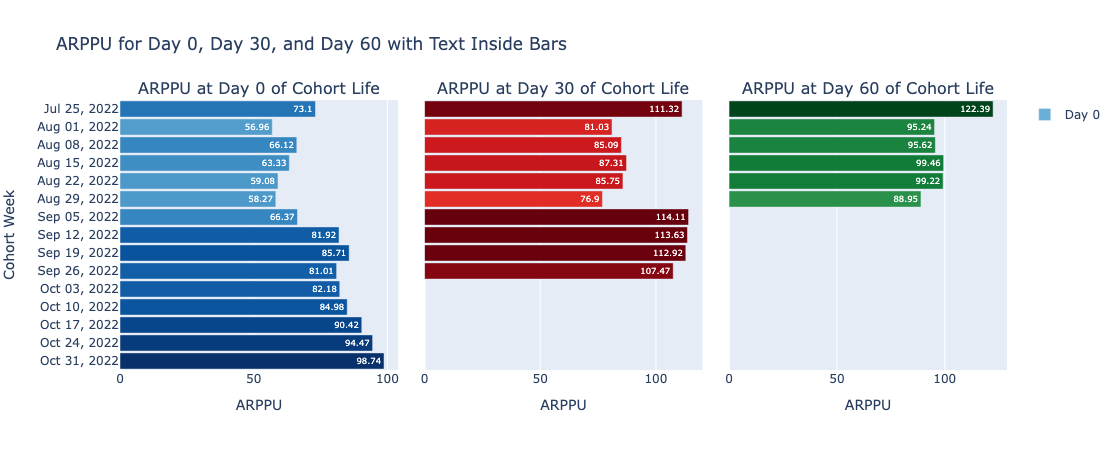

In [508]:
temp = temp.merge(temp1.groupby('cohort_week').agg(max_value_live_all_buyer_in_cohort=('days_leaving','min')).reset_index(), how='inner', on='cohort_week')

temp = temp.merge(temp.groupby('user_id').agg(date_of_fisrt_transaction=('data_chunk_date','min')).reset_index(), how='inner', on='user_id')

temp['diff_between_first_and_exect_trans'] = (pd.to_datetime(temp.data_chunk_date) - pd.to_datetime(temp.date_of_fisrt_transaction)).dt.days

result = pd.DataFrame()
for i in [0,30,60]:
    temporary = temp.copy()
    temporary = temporary.merge(temporary.groupby('cohort_week').agg(
            max_days_for_this_cohort=('max_value_live_all_buyer_in_cohort','min')).reset_index(),
            how='inner', on='cohort_week')
    temporary = temporary[temporary.max_days_for_this_cohort>= i]
    temporary = temporary[temporary['diff_between_first_and_exect_trans'] <=i].groupby('cohort_week').agg(buyers=('user_id','nunique'),
                                                                               revenue=('amount', 'sum')).reset_index()


    temporary['ARPPU'] = round(temporary.revenue/temporary.buyers,2)

    temporary['day'] = i

    
    result = pd.concat([result, temporary])

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Фільтрація для day = 0, day = 30 і day = 60
temp_day_0 = result[result['day'] == 0][['cohort_week', 'buyers', 'ARPPU']].copy()
temp_day_30 = result[result['day'] == 30][['cohort_week', 'buyers', 'ARPPU']].copy()
temp_day_60 = result[result['day'] == 60][['cohort_week', 'buyers', 'ARPPU']].copy()

# Максимальні значення ARPPU для кожного дня
max_arppu_0 = temp_day_0["ARPPU"].max()
max_arppu_30 = temp_day_30["ARPPU"].max()
max_arppu_60 = temp_day_60["ARPPU"].max()

# Перетворення cohort_week на текст із бажаним форматом
temp_day_0["cohort_week"] = temp_day_0["cohort_week"].dt.strftime('%b %d, %Y')
temp_day_30["cohort_week"] = temp_day_30["cohort_week"].dt.strftime('%b %d, %Y')
temp_day_60["cohort_week"] = temp_day_60["cohort_week"].dt.strftime('%b %d, %Y')

# Сортування cohort_week у порядку зверху вниз (хронологічно від найстарішого)
sorted_weeks = temp_day_0["cohort_week"].unique()[::-1]

# Створення subplot для трьох графіків
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=("ARPPU at Day 0 of Cohort Life", "ARPPU at Day 30 of Cohort Life", "ARPPU at Day 60 of Cohort Life"), 
    shared_yaxes=True, horizontal_spacing=0.03
)

# Додавання графіка для day = 0
fig.add_trace(
    go.Bar(
        x=temp_day_0["ARPPU"],
        y=temp_day_0["cohort_week"],
        orientation="h",
        marker=dict(color=temp_day_0["ARPPU"], colorscale="Blues", cmin=0, cmax=max_arppu_0),
        name="Day 0",
        text=temp_day_0["ARPPU"],
        textposition="inside",  # Текст всередині стовпця
        textfont=dict(color="white")  # Білий колір тексту
    ),
    row=1, col=1
)

# Додавання графіка для day = 30
fig.add_trace(
    go.Bar(
        x=temp_day_30["ARPPU"],
        y=temp_day_30["cohort_week"],
        orientation="h",
        marker=dict(color=temp_day_30["ARPPU"], colorscale="Reds", cmin=0, cmax=max_arppu_30),
        name="Day 30",
        text=temp_day_30["ARPPU"],
        textposition="inside",  # Текст всередині стовпця
        textfont=dict(color="white"),  # Білий колір тексту
        showlegend=False
    ),
    row=1, col=2
)

# Додавання графіка для day = 60
fig.add_trace(
    go.Bar(
        x=temp_day_60["ARPPU"],
        y=temp_day_60["cohort_week"],
        orientation="h",
        marker=dict(color=temp_day_60["ARPPU"], colorscale="Greens", cmin=0, cmax=max_arppu_60),
        name="Day 60",
        text=temp_day_60["ARPPU"],
        textposition="inside",  # Текст всередині стовпця
        textfont=dict(color="white"),  # Білий колір тексту
        showlegend=False
    ),
    row=1, col=3
)

# Налаштування осей і підплотів
fig.update_layout(
    height=450, 
    width=1200, 
    bargap=0.1,
    title_text="ARPPU for Day 0, Day 30, and Day 60 with Text Inside Bars",
    coloraxis_showscale=False,  # Вимкнення спільної шкали кольорів
    xaxis_title="ARPPU",  # Загальний підпис осі X
    xaxis2_title="ARPPU",  # Підпис для другого графіка
    xaxis3_title="ARPPU"   # Підпис для третього графіка
)

# Сортування осі y
fig.update_yaxes(
    categoryorder="array",
    categoryarray=sorted_weeks,
    title_text="Cohort Week",
    row=1, col=1
)

# Видалення назви осі Y і тікетів для інших графіків
fig.update_yaxes(showticklabels=False, row=1, col=2)
fig.update_yaxes(showticklabels=False, row=1, col=3)

fig.show()

## **2. Визначення прохідності платежів на покупку підписки**

### **Як ми це зробимо:**

1. **Додавання маркеру прохідності платежів:**
   - Додаємо новий стовпець `payment_passed`, який позначає, чи пройшла оплата.
   - Вважаємо, що оплата пройшла, якщо статус транзакції — `success` або `refunded`.

2. **Агрегація даних за методом оплати:**
   - Для кожного методу оплати обчислюємо:
     - Загальну кількість транзакцій (`total_number_of_transactions`).
     - Кількість успішних транзакцій (`number_of_passed`).
   - Розраховуємо відсоток успішних транзакцій (`payment_success_rate`), який показує, наскільки ефективно проходять платежі для кожного методу.

3. **Агрегація даних за методом оплати та валютою:**
   - Аналогічно до попереднього кроку, але додаємо розподіл за валютою (`currency`).
   - Це дозволяє оцінити, чи є відмінності в прохідності платежів між валютами (наприклад, USD і CAD) для одного й того ж методу оплати.

In [509]:
temp = df.copy()
temp['payment_passed'] = temp.status.isin(['success', 'refunded'])
temp.head()

temp1 = temp.groupby('payment_method').agg(total_number_of_transactions=('user_id','count'),
                                   number_of_passed = ('payment_passed', 'sum')).reset_index()
temp1['payment_success_rate'] = round(temp1.number_of_passed/temp1.total_number_of_transactions*100,2)


temp2 = temp.groupby(['payment_method', 'currency']).agg(total_number_of_transactions=('user_id','count'),
                                   number_of_passed = ('payment_passed', 'sum')).reset_index()
temp2['payment_success_rate'] = round(temp2.number_of_passed/temp2.total_number_of_transactions*100,2)


In [510]:
temp1

,payment_method,total_number_of_transactions,number_of_passed,payment_success_rate
0,Apple Pay,1459,671,45.99
1,Card,5050,2373,46.99


In [511]:
temp2

,payment_method,currency,total_number_of_transactions,number_of_passed,payment_success_rate
0,Apple Pay,CAD,22,19,86.36
1,Apple Pay,USD,1437,652,45.37
2,Card,CAD,153,114,74.51
3,Card,USD,4897,2259,46.13


### **Висновки по Payment Success Rate**

- **Apple Pay**:
  - Успішність платежів — **45.99%**.
  - У валюті **CAD** — **86.36%** (22 транзакції).
  - У валюті **USD** — **45.37%**.

- **Card**:
  - Успішність платежів — **46.99%**.
  - У валюті **CAD** — **74.51%**.
  - У валюті **USD** — **46.13%**.

## **3. Обчислення Churn Rate на чарджах у перший місяць підписки**

### **Основна логіка:**
1. **Підготовка даних:**
   - Виділяємо перше слово з опису транзакції (`description`) для класифікації типів транзакцій.
   - Сортуємо транзакції за користувачами та часом їх створення.

2. **Фільтрація користувачів:**
   - Вибираємо лише тих користувачів, у яких перша транзакція була `Subscription` (успішна, але не `refunded`).
   - Видаляємо всіх інших користувачів.

3. **Робота із транзакціями:**
   - Фільтруємо дані, залишаючи лише транзакції типу `Subscription` та `Renew`.
   - Обчислюємо час від першої транзакції для кожного користувача.

4. **Аналіз за перший місяць:**
   - Вибираємо лише транзакції, які відбулися протягом перших 30 днів з моменту першої підписки.
   - Підраховуємо кількість користувачів, які зробили транзакцію типу `Renew`.

5. **Розрахунок Churn Rate:**
   - Розраховуємо відсоток користувачів, які не зробили `Renew` у перший місяць:

In [512]:
temp = df.copy()

# Додавання нового стовпця з першим словом із description
temp['first_word'] = temp['description'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)

temp = temp.sort_values(by=['user_id','created_at'])

temp = temp[temp.status.isin(['success','refunded'])]

# Ранжування транзакцій кожного користувача
temp['rank'] = temp.groupby('user_id')['created_at'].rank(
    method='dense',  # Однаковий час отримує однаковий ранг
    ascending=True   # Ранжування за зростанням
).astype(int)

t1 = temp[temp['rank'] == 1]
lst_of_users_only_first_success_sub = t1[(t1.first_word == 'Subscription') & (t1.status != 'refunded')].user_id.unique()

temp = temp[temp.user_id.isin(lst_of_users_only_first_success_sub)]

# Фільтрація лише транзакцій із first_word == 'Subscription' та 'Renew'
subscription_types = ['Subscription', 'Renew']
temp_filtered = temp[temp['first_word'].isin(subscription_types)].copy()

temp_filtered = temp_filtered.merge(temp_filtered.groupby('user_id').agg(date_of_first_transaction = ('created_at','min')).reset_index(),
                    on='user_id', how='inner')

temp_filtered['time_from_first_transaction'] = (temp_filtered.created_at - temp_filtered.date_of_first_transaction).dt.days

temp_filtered = temp_filtered[temp_filtered.time_from_first_transaction <= 30]

users_w_renew = temp_filtered[temp_filtered.first_word == 'Renew'].user_id.nunique()

total_user_w_first_sub = temp_filtered.user_id.nunique()

print(f'Churn Rate в Renew підписки який відбувається на 30 день = {round((total_user_w_first_sub-users_w_renew)/total_user_w_first_sub*100,2)} %')

Churn Rate в Renew підписки який відбувається на 30 день = 75.14 %


### **Висновки:**
1. **Churn Rate на чарджах у перший місяць підписки становить 75.14%.**
2. Є користувачі, у яких перша підписка була успішною, але вони зробили `refunded` для неї і навіть мали успішний `Renew`. Таких користувачів ми не враховуємо.
3. **Поведінка транзакцій:**
   - `Renew` завжди відбувається на 30-й день.
   - `Retry` трапляється завжди на 31-й день або пізніше.
4. **Статистика статусів транзакцій:**
   - `Subscription`: 3204
   - `Retry`: 1297
   - `Renew`: 1240
   - `Upsell`: 632
   - `Upgrade`: 136
5. Інколи в один і той же момент часу (до мілісекунди) трапляються кілька транзакцій, наприклад, `Subscription` разом із `Upsell` чи `Upgrade`, що додає певної плутанини у дані.

## **4. Логіка підрахунків**

**Логіка розрахунків була детально описана на кожному етапі, вище.**

## **5. Яку додаткову інформацію можна отримати з цих даних?**

З аналізованих даних можна отримати наступну додаткову інформацію, яка стосується різних аспектів бізнесу:

---

### **1. ARPPU (Average Revenue Per Paying User):**
- **Аналіз динаміки ARPPU:**
  - Порівняння ARPPU між когортами (денна, тижнева, місячна).
  - Порівняння ARPPU за часом життя (0, 30, 60 днів).
  - Порівняння ARPPU між когортами (по різних екшенах: Retry, Upgrade, Renew тощо).
  - Визначення найбільш "прибуткових" когорт для таргетування.
- **Вплив змін цін:**
  - Як зміна ціни підписки з $49 до $69 вплинула на ARPPU.
  - Вплив Premium-підписок на ARPPU.

---

### **2. Churn Rate:**
- **Сегментація Churn Rate:**
  - Порівняння Churn Rate між когортами (денна, тижнева, місячна).
  - Порівняння Churn Rate між когортами (по різних екшенах: Retry, Upgrade, Renew тощо).
  - Аналіз Churn Rate для різних когорт за часом (0, 30, 60 днів).
- **Визначення ключових факторів:**
  - Оцінка ролі `Retry` у зменшенні Churn Rate.

---

### **3. Payment Success Rate:**
- **Прохідність платежів:**
  - Які методи оплати мають найкращий Payment Success Rate.
  - Вплив валюти (CAD vs USD) на успішність платежів.

---

### **4. Поведінковий аналіз користувачів:**
- **Аналіз Upsell/Upgrade:**
  - Чи впливають `Upsell` або `Upgrade` на ARPPU та утримання.
- **Поведінка користувачів із Refund:**
  - Аналіз користувачів, які зробили `refunded` після першої успішної транзакції, та їх подальша активність (є ті, хто потім мав успішний Renew).

---

### **5. Аналіз за ринками (США та Канада):**
- **Частка Premium-підписок:**
  - Аналіз, чи є ринок, на якому Premium підписки мають більшу популярність.

---

### **6. Динаміка повторних транзакцій:**
- **Часові патерни:**
  - Як часто користувачі здійснюють `Retry` або `Renew`.
  - Середній час до `Retry` для користувачів із невдалими платежами.
- **Відсоток успіху Retry:**
  - Який відсоток `Retry` завершується успішно.

---

### **7. Retention Rate:**
- **Когортний аналіз Retention Rate:**
  - Визначення, який відсоток користувачів залишається активним через 30, 60, 90 днів після першої транзакції.
- **Retention у розрізі продуктів:**
  - Оцінка, чи утримуються користувачі, які купують Premium-підписки, краще, ніж базові підписники.
- **Retention для різних ринків:**
  - Порівняння Retention Rate між США та Канадою.

---

### **8. Revenue Retention (Gross Revenue Retention):**
- **Аналіз Revenue Retention:**
  - Як зміни в доході зберігаються з часом у різних когорт.
  - Чи зростає дохід від когорт із Upsell або Premium.
- **Вплив Churn на Revenue Retention:**
  - Які когорти генерують найбільше повторних платежів.

---

### **9. Lifetime Value (LTV):**
- **Когортний аналіз LTV:**
  - Оцінка довгострокової вартості користувачів, які здійснюють повторні покупки (Renew, Upsell).
- **Сегментація LTV:**
  - Розрахунок LTV для різних сегментів (Premium-підписки, Retry, різні ринки).
- **Вплив Churn на LTV:**
  - Як Churn Rate впливає на LTV для різних когорт.

---

### **10. Прогнозування (Forecasting):**
- **Прогноз доходу:**
  - Використання трендів ARPPU, Retention та Churn для прогнозування доходів у майбутніх періодах.
- **Оцінка впливу змін:**
  - Як нові пропозиції або ціни можуть вплинути на показники когорт.

---

### **11. Оцінка сезонності:**
- **Визначення трендів:**
  - Чи є сезонні впливи на підписки або транзакції.

## **6. Які інші метрики можуть бути корисними для аналізу бізнесу на основі наданих даних?**

### **1. Метрики користувачів**
- **Retention Rate:** Відсоток користувачів, які залишаються активними через 30, 60 днів.
- **Cohort Retention:** Утримання користувачів за когортами.

---

### **2. Метрики доходу**
- **ARPPU (Average Revenue Per Paying User):** Порівняння за когортами та часом (0, 30, 60 днів).
- **Revenue Churn Rate:** Втрата доходу через відмову від підписок.

---

### **3. Метрики платежів**
- **Payment Success Rate:** Успішність транзакцій для методів оплати та валют.
- **Retry Success Rate:** Успішність платежів після `Retry`.

---

### **4. Поведінковий аналіз**
- **Upsell/Upgrade Rate:** Частка користувачів, які здійснили Upsell або Upgrade.
- **Retry Patterns:** Середній час до першого `Retry` та його ефективність.

---

### **5. Метрики ринку**
- **Revenue per Region:** Порівняння доходів між ринками (США та Канада).
- **Market Share per Region:** Частка користувачів між ринками.

---

### **6. Метрики продукту**
- **Lifetime Value (LTV):** Довгострокова вартість користувача.
- **Refund Rate:** Частка транзакцій, які були повернуті.

---

### **7. Прогнозування та сезонність**
- **Seasonality Analysis:** Визначення сезонних трендів у підписках.
- **Revenue Forecasting:** Прогноз доходів на основі Retention Rate та ARPPU.

---

### **Додаткові пропозиції**
- Виконати когортний аналіз для ARPPU, Churn Rate, Retention.
- Вивчити вплив Upsell/Upgrade на Retention та ARPPU.

## **7. Рекомендації щодо автоматизації звітності для бізнесу**

### **1. Збір та зберігання даних**
- **Джерело даних:** 
  - Якщо дані з Amplitude, налаштуйте їх експорт до бази даних.
  - Якщо дані вже в базі даних, переходьте до інтеграції.
  - Наситити базу даних додатково клієнтськими даними і маркетинговими.
- **Зберігання:** Використовуйте централізовану базу даних (SQL чи хмарну платформу) для забезпечення доступності даних.

---

### **2. Інтеграція з Tableau**
- Підключити Tableau безпосередньо до бази даних або іншого джерела даних.

---

### **3. Розробка дашборду**
- Створити дашборди з основними метриками.

---

### **4. Автоматизація оновлення**
- Поставити на щоденне оновлення даних дашборд.

---

### **5. Виставлення Трешхолдів, GOAL**
- Позначити для Service Level метрик, показники, яких намагаємось досягти, або за які не повинні вирости впасти.

---

## **8. Як побудувати звітність і які інструменти використовувати**

### **1. Архітектура звітності**
1. **Джерело даних:**
   - Якщо дані в Amplitude:
     - Перелив би дані в базу даних, бо наскільки знаю напряму з amplitude не можна тягнути дані в Табло.

2. **Сховище:**
   - Використовуйте хмарну платформу (BigQuery) або локальну базу даних (PostgreSQL, MySQL, Clickhouse) для централізації даних.

3. **ETL-процес:**
   - Інструменти для екстракції, трансформації та завантаження (ETL), наприклад:
     - **Airflow**, **dbt** — для автоматизації обробки даних.
   - Перевіряйте якість даних перед завантаженням у сховище.

4. **Візуалізація:**
   - Інструмент: **Tableau** (або альтернативи, superset - але він менш гнучкий).
